In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch,ArrayDataset, GridPatchDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet

from torch.utils.tensorboard import SummaryWriter
import monai
from monai.transforms import (
    Activations,
    Activationsd,
    AddChannel,
    AsDiscrete,
    AsDiscreted,
    AsChannelFirst,
    Compose,
    ConvertToMultiChannelBasedOnBratsClassesd,
    Invertd,
    LoadImaged,
    LabelToMask,
    LoadImage,
    MapTransform,
    NormalizeIntensity,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    RandSpatialCrop,
    Resize,
    RandFlip,
    RandRotate,
    Spacing,
    Spacingd,
    ScaleIntensity, 
    SpatialCrop,
    ToTensor,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Resized
)
from monai.utils import set_determinism
from natsort import natsorted
import torch

from glob import glob
import os.path
import nibabel as nib
from nibabel import load, save, Nifti1Image


print_config()



MONAI version: 0.8.0
Numpy version: 1.21.2
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)


/Users/sebastianotalora/work/postdoc/federated_learning/fedem/data


In [3]:
LIEU = 'sebastian_laptop'

if LIEU=='sebastian_workstation':
    root_brats_data = '/media/sebastian/data/ASAP/BRATS_2019_ubelix/HGG/'
    brats_nifti__dir_paths = natsorted(glob(root_brats_data+"**/*"))

if LIEU=='sebastian_laptop':
    root_brats_data = '/Users/sebastianotalora/work/postdoc/federated_learning/data/brats/'
    brats_nifti__dir_paths = natsorted(glob(root_brats_data+"**/**/"))



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
set_determinism(seed=0)

In [6]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)


In [7]:
# here we don't cache any data in case out of memory issue
#train_ds = DecathlonDataset(
#    root_dir=root_dir,
#    task="Task01_BrainTumour",
#    transform=train_transform,
#    section="training",
#    download=True,
#    cache_rate=0.0,
#    num_workers=0,
#)
#train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

In [11]:
brats_nifti_labels = []#natsorted(glob(root_brats_data+"**/"+'gt*nii*'))
brats_nifti_flair = []#natsorted(glob(root_brats_data+"**/"+'flair*nii*'))
brats_nifti_t1 = []#natsorted(glob(root_brats_data+"**/"+'t1*nii*'))
brats_nifti_t1ce = []# natsorted(glob(root_brats_data+"**/"+'t1*nii*'))
brats_nifti_t2 = [] #natsorted(glob(root_brats_data+"**/"+'t2*nii*'))
brats_niftis_stacked = []

In [12]:
count_saving = 0
for item in brats_nifti__dir_paths:
    brats_nifti_labels.append(item+"gt.nii.gz")
    brats_nifti_flair.append(item+"flair.nii.gz")
    brats_nifti_t1.append(item+"t1.nii.gz")
    brats_nifti_t1ce.append(item+"t1ce.nii.gz")
    brats_nifti_t2.append(item+"t2.nii.gz")
    brats_niftis_stacked.append(item+"stacked.nii.gz")
    #assert(os.path.isfile(brats_nifti_labels[-1])==os.path.isfile(brats_nifti_flair[-1])==os.path.isfile(brats_nifti_t1[-1])==os.path.isfile(brats_nifti_t1ce[-1])==os.path.isfile(brats_nifti_t2[-1]))
    #flair_sample      = nib.load(brats_nifti_flair[-1])
    #t1_sample         = nib.load(brats_nifti_t1[-1])
    #brats_nifti_t1ce_sample  = nib.load(brats_nifti_t1ce[-1])
    #brats_nifti_t2_sample    = nib.load(brats_nifti_t2[-1])
    #img_np = flair_sample.get_fdata()
    #stacked_4d_nifti = np.zeros((flair_sample.shape[0],flair_sample.shape[1],flair_sample.shape[2],4),dtype='float64')
    #stacked_4d_nifti[:,:,:,0] = flair_sample.get_fdata()
    #stacked_4d_nifti[:,:,:,1] = t1_sample.get_fdata()
    #stacked_4d_nifti[:,:,:,2] = brats_nifti_t1ce_sample.get_fdata()
    #stacked_4d_nifti[:,:,:,3] = brats_nifti_t2_sample.get_fdata()
    #print("Saving nifti "+str(count_saving) + " out of " + str(len(brats_nifti__dir_paths)))
    #out = Nifti1Image(stacked_4d_nifti, header=flair_sample.header, affine=flair_sample.affine)
    #save(out, item+'stacked.nii.gz')    
    #count_saving+=1

In [13]:
pds = ArrayDataset([1, 2, 3, 4], lambda x: x + 0.1)

In [14]:
pds[0]

1.1

In [15]:
print(len(brats_nifti_labels), len(brats_niftis_stacked),len(brats_nifti_flair), len(brats_nifti_t1),len(brats_nifti_t1ce),len(brats_nifti_t2))

259 259 259 259 259 259


In [18]:
class ConvertLabelBrats(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WC (Whole tumor)*** we want WC because flair shows whole tumor
    and ET (Enhancing tumor).
   """

    def __call__(self, data):
        first_label_map = torch.tensor(np.array(data) == 1, dtype=torch.uint8)
        second_label_map = torch.tensor(np.array(data) == 2,dtype=torch.uint8)
        third_label_map = torch.tensor(np.array(data) == 4,dtype=torch.uint8)
        return torch.vstack((first_label_map,second_label_map,third_label_map))

In [19]:
imtrans = Compose(
    [   LoadImage(image_only=True),
         Spacing(
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
            image_only = True,
        ),
        #ScaleIntensity(),
        #NormalizeIntensity(nonzero=True, channel_wise=True),
        AsChannelFirst(),
        ToTensor(),
        #AddChannel(),
        #EnsureType(),
        #Resized,
        #RandFlip(prob=0.5, spatial_axis=0),
        RandRotate(),
        NormalizeIntensity(nonzero=True, channel_wise=True),
        Resize(spatial_size=(112,112,72))
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),
        #AsChannelFirst(),
        ToTensor(),
        AddChannel(),
        ConvertLabelBrats(keys=(1,2,4)),
         #EnsureType(),
        #Resized,
        Resize(spatial_size=(112,112,72),mode='nearest')
    ]
)

In [20]:
#train_files = [{"image": img, "label": seg} for img, seg in zip(brats_niftis_stacked, brats_nifti_labels)]
#train_ds = monai.data.CacheDataset(data=train_files, transform=imtrans, cache_rate=1.0)

In [21]:
#train_ds[0]['image'].shape

In [22]:
#monai.data.CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
#stacked_labels = monai.data.CacheDataset(data=brats_nifti_labels, transform=segtrans, cache_rate=1.0)#ArrayDataset(brats_niftis_stacked, imtrans, brats_nifti_labels, segtrans)
#stacked_ds = monai.data.CacheDataset(data=brats_niftis_stacked, transform=imtrans, cache_rate=1.0)#ArrayDataset(brats_niftis_stacked, imtrans, brats_nifti_labels, segtrans)

In [23]:
stacked_ds    = ArrayDataset(brats_niftis_stacked, imtrans, brats_nifti_labels, segtrans)

In [24]:
train_loader = DataLoader(stacked_ds, batch_size=1, shuffle=True, num_workers=0)

In [25]:
len(stacked_ds[0])

/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


2

In [26]:
print(stacked_ds[0][0].shape,stacked_ds[0][1].shape)#sample,C, H,W,D

/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


torch.Size([4, 112, 112, 72]) torch.Size([3, 112, 112, 72])


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


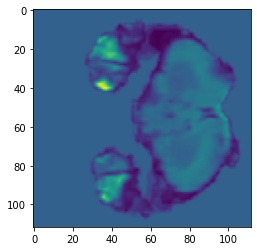

In [27]:
plt.imshow(stacked_ds[0][0][0,:,:,10])

/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


image shape: torch.Size([112, 112])


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim fr

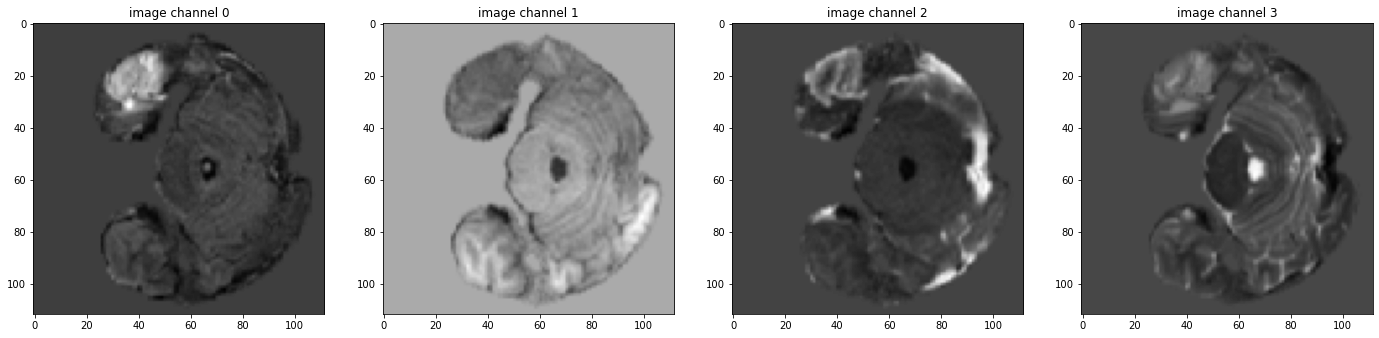

/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


label shape: torch.Size([112, 112])


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


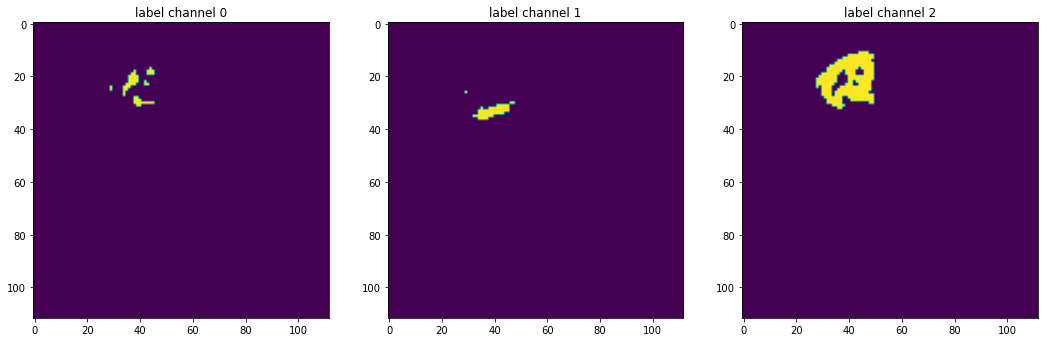

In [29]:
sample = 70
slice_num = 20
print(f"image shape: {stacked_ds[sample][0][0,:,:,slice_num].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(stacked_ds[sample][0][i,:,:,slice_num].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {stacked_ds[sample][1][0,:,:,slice_num].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(stacked_ds[sample][1][i,:, :, slice_num].detach().cpu()*255)
plt.show()


In [30]:
device

device(type='cpu')

In [31]:
max_epochs = 300
val_interval = 1
VAL_AMP = False

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(logit_thresh=0.5)]
)


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = False


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [32]:
model.spatial_dims

3

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(1):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:#train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data[0].to(device),
            batch_data[1].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(stacked_ds) // 1}"
            #f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start


----------
epoch 1/300


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1/259, train_loss: 0.9496, step time: 6.6357


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


2/259, train_loss: 0.9256, step time: 6.8193


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


3/259, train_loss: 0.9843, step time: 6.6803


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


4/259, train_loss: 0.9834, step time: 6.4585


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


5/259, train_loss: 0.9057, step time: 6.4382


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


6/259, train_loss: 0.9529, step time: 6.4087


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


7/259, train_loss: 0.9490, step time: 6.4362


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


8/259, train_loss: 0.9867, step time: 6.4485


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


9/259, train_loss: 0.9244, step time: 6.4494


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


10/259, train_loss: 0.8980, step time: 6.4972


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11/259, train_loss: 0.9345, step time: 6.4871


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


12/259, train_loss: 0.9870, step time: 6.4374


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


13/259, train_loss: 0.8830, step time: 6.4571


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


14/259, train_loss: 0.9235, step time: 6.4848


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


15/259, train_loss: 0.9267, step time: 6.4467


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


16/259, train_loss: 0.9016, step time: 6.4316


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


17/259, train_loss: 0.8693, step time: 6.4442


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


18/259, train_loss: 0.9572, step time: 6.4739


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


19/259, train_loss: 0.9647, step time: 6.9613


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


20/259, train_loss: 0.9145, step time: 7.3647


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


21/259, train_loss: 0.9837, step time: 7.1073


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


22/259, train_loss: 0.8751, step time: 7.0326


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


23/259, train_loss: 0.9728, step time: 7.2632


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


24/259, train_loss: 0.9430, step time: 8.1096


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


25/259, train_loss: 0.8438, step time: 8.2006


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


26/259, train_loss: 0.9801, step time: 7.6755


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


27/259, train_loss: 0.9400, step time: 7.6362


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


28/259, train_loss: 0.8679, step time: 8.0152


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


29/259, train_loss: 0.9192, step time: 7.8936


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


30/259, train_loss: 0.8899, step time: 7.0945


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


31/259, train_loss: 0.9249, step time: 6.9453


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


32/259, train_loss: 0.8575, step time: 6.4488


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


33/259, train_loss: 0.9587, step time: 6.4700


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


34/259, train_loss: 0.9067, step time: 6.4338


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


35/259, train_loss: 0.9477, step time: 6.8083


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


36/259, train_loss: 0.8852, step time: 6.4861


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


37/259, train_loss: 0.9742, step time: 6.5315


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


38/259, train_loss: 0.9610, step time: 6.4240


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


39/259, train_loss: 0.8911, step time: 6.5364


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


40/259, train_loss: 0.8510, step time: 6.4938


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


41/259, train_loss: 0.9835, step time: 6.5132


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


42/259, train_loss: 0.8469, step time: 6.4679


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


43/259, train_loss: 0.9567, step time: 6.5490


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


44/259, train_loss: 0.9762, step time: 6.4561


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


45/259, train_loss: 0.9034, step time: 6.4478


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


46/259, train_loss: 0.9924, step time: 6.4940


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


47/259, train_loss: 0.9270, step time: 6.5425


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


48/259, train_loss: 0.9643, step time: 6.4483


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


49/259, train_loss: 0.9799, step time: 6.4611


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


50/259, train_loss: 0.8623, step time: 6.4905


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


51/259, train_loss: 0.9587, step time: 6.4627


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


52/259, train_loss: 0.9115, step time: 6.8453


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


53/259, train_loss: 0.9549, step time: 6.7434


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


54/259, train_loss: 0.8717, step time: 6.5109


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


55/259, train_loss: 0.9692, step time: 6.4437


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


56/259, train_loss: 0.8730, step time: 6.5401


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


57/259, train_loss: 0.9588, step time: 6.9671


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


58/259, train_loss: 0.8259, step time: 6.6138


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


59/259, train_loss: 0.9782, step time: 6.5347


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


60/259, train_loss: 0.9136, step time: 6.4907


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


61/259, train_loss: 0.8578, step time: 6.6155


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


62/259, train_loss: 0.9829, step time: 6.5888


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


63/259, train_loss: 0.8924, step time: 6.4921


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


64/259, train_loss: 0.9665, step time: 6.4430


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


65/259, train_loss: 0.9258, step time: 6.4463


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


66/259, train_loss: 0.8763, step time: 6.4642


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


67/259, train_loss: 0.9700, step time: 6.5775


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


68/259, train_loss: 0.9327, step time: 6.4783


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


69/259, train_loss: 0.9313, step time: 6.7580


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


70/259, train_loss: 0.9012, step time: 6.4757


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


71/259, train_loss: 0.9109, step time: 6.5551


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


72/259, train_loss: 0.9391, step time: 6.4539


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


73/259, train_loss: 0.8880, step time: 6.4447


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


74/259, train_loss: 0.9442, step time: 6.4602


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


75/259, train_loss: 0.9736, step time: 6.4933


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


76/259, train_loss: 0.8990, step time: 7.0174


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


77/259, train_loss: 0.8727, step time: 7.0365


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


78/259, train_loss: 0.9434, step time: 7.0104


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


79/259, train_loss: 0.9486, step time: 7.1532


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


80/259, train_loss: 0.8668, step time: 7.3063


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


81/259, train_loss: 0.8863, step time: 7.3478


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


82/259, train_loss: 0.8649, step time: 7.3263


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


83/259, train_loss: 0.9386, step time: 7.3758


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


84/259, train_loss: 0.8685, step time: 7.3923


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


85/259, train_loss: 0.8470, step time: 7.3088


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


86/259, train_loss: 0.9646, step time: 7.1355


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


87/259, train_loss: 0.9375, step time: 7.0598


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


88/259, train_loss: 0.8701, step time: 7.0592


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


89/259, train_loss: 0.9113, step time: 6.9340


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


90/259, train_loss: 0.8617, step time: 6.7463


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


91/259, train_loss: 0.9525, step time: 6.5618


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


92/259, train_loss: 0.8893, step time: 6.6106


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


93/259, train_loss: 0.9643, step time: 6.7234


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


94/259, train_loss: 0.9526, step time: 6.7737


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


95/259, train_loss: 0.9724, step time: 7.7495


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


96/259, train_loss: 0.8168, step time: 7.5114


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


97/259, train_loss: 0.8868, step time: 7.5701


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


98/259, train_loss: 0.8904, step time: 8.6466


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


99/259, train_loss: 0.9223, step time: 9.0660


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


100/259, train_loss: 0.9234, step time: 10.1936


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


101/259, train_loss: 0.8832, step time: 9.5398


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


102/259, train_loss: 0.8414, step time: 7.9819


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


103/259, train_loss: 0.9698, step time: 7.2410


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


104/259, train_loss: 0.8868, step time: 7.1844


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


105/259, train_loss: 0.9728, step time: 7.2513


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


106/259, train_loss: 0.9634, step time: 6.9564


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


107/259, train_loss: 0.8796, step time: 7.4265


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/data/utils.py:532: UserWarning: Modifying image pixdim from [1. 1. 1. 1.] to [  1.           1.           1.         239.00209204]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [59]:
print(inputs.shape, labels.shape)

torch.Size([1, 4, 100, 100, 50]) torch.Size([1, 3, 100, 100, 50])


In [62]:
inputs[:,:,:,:].shape

torch.Size([1, 4, 100, 100, 50])

In [60]:
print(inputs.shape, labels.shape)

torch.Size([1, 4, 142, 179, 129]) torch.Size([1, 142, 179, 129])


In [62]:
model(inputs[:,:,0:120,0:120,0:120]).shape

torch.Size([1, 3, 120, 120, 120])

In [28]:
model.double()

SegResNet(
  (act): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affi

In [29]:
device

'cpu'

In [68]:
outputs = model(torch.tensor(np.zeros((1,4,112,112,72)).astype('float32')).to(device))

In [69]:
outputs.shape

torch.Size([1, 3, 112, 112, 72])

In [15]:
torch.save(         model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )

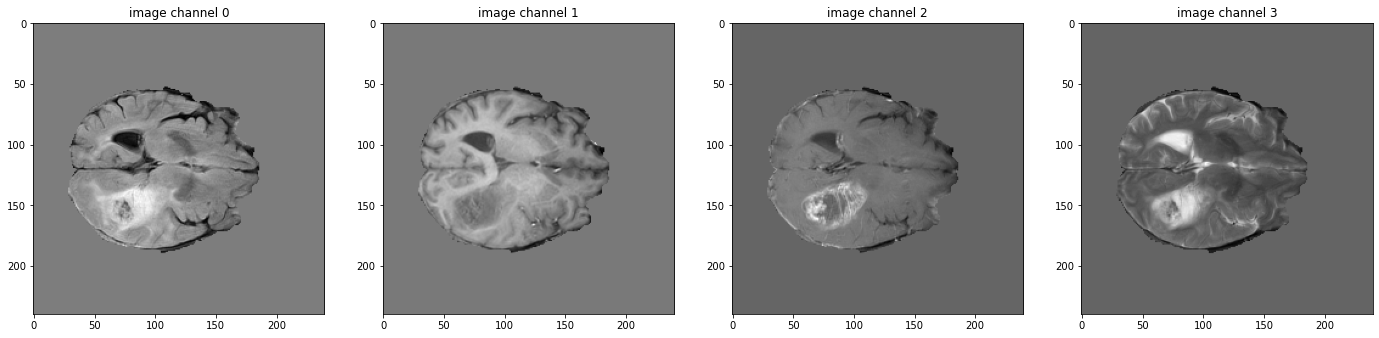

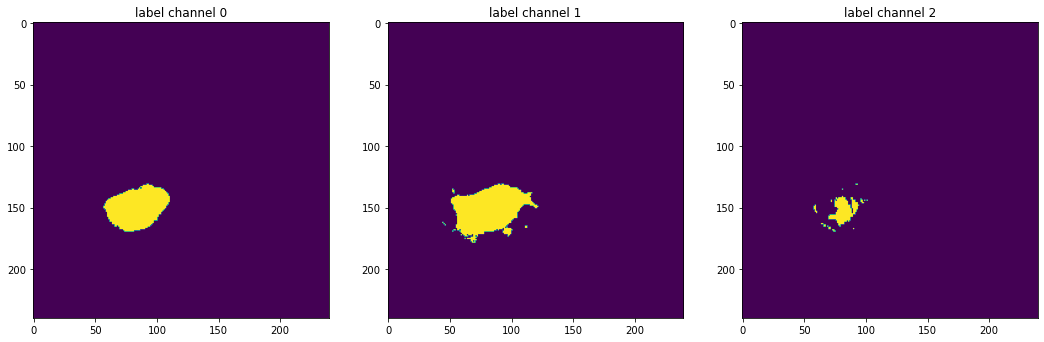

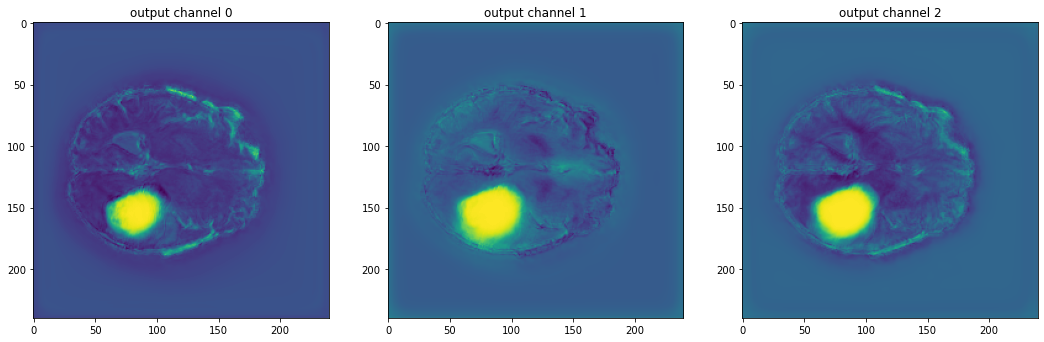

In [16]:
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()


In [83]:
DecathlonDataset??

In [26]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        Orientationd(keys=["image"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=0,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=0)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", logit_thresh=0.5),
])


In [27]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch[0].item(), metric_batch[1].item(), metric_batch[2].item()

print("Metric on original image spacing: ", metric)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")


/opt/anaconda3/envs/fed/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/opt/anaconda3/envs/fed/lib/python3.9/site-packages/monai/metrics/meandice.py:73: UserWarning: y_pred should be a binarized tensor.
  warnings.warn("y_pred should be a binarized tensor.")


NameError: name 'metric_batch' is not defined